In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from datasets import PascalVOC
from utils import scale_bbs, plot_with_bbs, show_img, plot_with_bbs2
from bbox_utils import bbox_transform_inv, clip_boxes

from models import Base_CNN, RegionProposalNetwork, ROIPooling, FRCNN
from criterion import RPNLoss, FRCNNLoss

In [2]:
path =  '/home/austin/data/VOC/VOC2007/'


In [3]:
trans = transforms.Compose([transforms.Scale(600),
                            transforms.ToTensor()])

In [4]:
voc = PascalVOC(root=path+'JPEGImages', annFile=path+"pascal_train2007.json", transform=trans)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


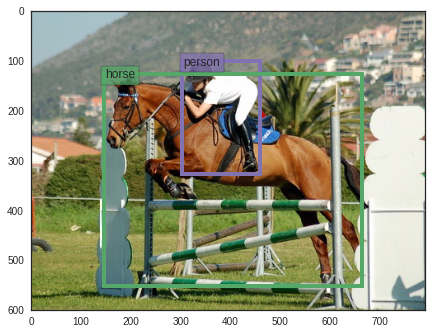

In [5]:
test_idx = 1
classes = voc.classes
img, target = voc[test_idx]
plot_with_bbs(img, target, classes)

In [6]:
classes[15], classes[13]

('person', 'horse')

In [7]:
target

[{'area': 13110,
  'bbox': [303, 100, 156, 227],
  'category_id': 15,
  'height': 364,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'scale': (1.6479166666666667, 1.6483516483516483),
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'width': 480},
 {'area': 81326,
  'bbox': [146, 126, 517, 426],
  'category_id': 13,
  'id': 3,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]]}]

## Generate VGG Features

In [8]:
base_cnn = Base_CNN()
img_features = base_cnn(Variable(img.unsqueeze(0)))
img_features.size()

torch.Size([1, 512, 37, 49])

## Generate Anchors
- (Multi-Scale Anchors as Regression References)

In [9]:
rpn = RegionProposalNetwork()
rpn._anchors

array([[ -84.,  -40.,   99.,   55.],
       [-176.,  -88.,  191.,  103.],
       [-360., -184.,  375.,  199.],
       [ -56.,  -56.,   71.,   71.],
       [-120., -120.,  135.,  135.],
       [-248., -248.,  263.,  263.],
       [ -36.,  -80.,   51.,   95.],
       [ -80., -168.,   95.,  183.],
       [-168., -344.,  183.,  359.]])

## Features  through RPN to get bounding box deltas and class scores

In [10]:
rpn = RegionProposalNetwork()
rpn_cls_prob, rpn_bbox_pred = rpn(img_features)
rpn_cls_prob.size(), rpn_bbox_pred.size()

(torch.Size([16317, 2]), torch.Size([16317, 4]))

## generate RPN targets

In [11]:
labels, bbox_targets = rpn.get_rpn_targets(target, img)

## RPN loss

In [12]:
rpn_loss = RPNLoss()
rpn_loss(rpn_cls_prob, rpn_bbox_pred, Variable(labels), Variable(bbox_targets))

Variable containing:
 0.8642
[torch.FloatTensor of size 1]

## Use deltas to transform anchor boxes, also threshold boxes with nms to get propsal boxes max(300, 4)

In [13]:
roi_boxes, scores = rpn.get_roi_boxes(rpn_bbox_pred, rpn_cls_prob, img, target, test=False)
roi_boxes.shape, scores.shape # objectness scores

((1, 4, 4), (1, 4))

### Proposed regions

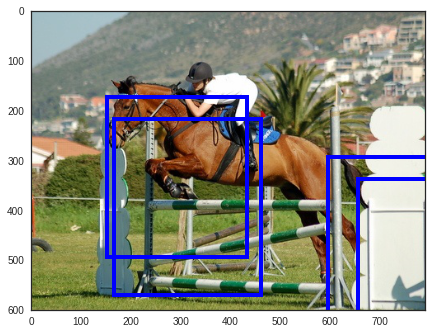

In [14]:
plot_with_bbs2(img, roi_boxes[0])

## FRCNN targets

In [15]:
frcnn = FRCNN()

In [16]:
frcnn_labels, roi_boxes, frcnn_bbox_targets = frcnn.get_frcnn_targets(roi_boxes, target, test=False)

In [17]:
frcnn_labels, roi_boxes

(
  13
   0
   0
 [torch.LongTensor of size 3],
 array([[ 146.        ,  126.        ,  517.        ,  426.        ,    0.        ],
        [ 152.16610718,  172.94485474,  281.55419922,  320.0788269 ,    0.        ],
        [ 152.16610718,  172.94485474,  281.55419922,  320.0788269 ,    0.        ]]))


## ROIpool the selected rois (inserted as first layer of frcnn)
- input img, roi output --> (1, num_rois, channels, 7, 7) or (1, 32, 3, 7, 7) small images for us to classify


## Final Classifier
- flatten and apply classification + regress each roi

In [18]:
cls_pred, bb_pred = frcnn(img_features, roi_boxes)

In [19]:
cls_pred.size(), bb_pred.size() # predictions for our rois

(torch.Size([3, 21]), torch.Size([3, 84]))

## FRCNN loss


In [23]:
frcnn_loss = FRCNNLoss()

In [24]:
frcnn_loss(cls_pred, bb_pred, Variable(frcnn_labels), Variable(frcnn_bbox_targets))

Variable containing:
1.00000e-03 *
  7.7834
[torch.FloatTensor of size 1]

Variable containing:
 2.9590
[torch.FloatTensor of size 1]



TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

## get pred labels and bounding boxes for lables

In [ ]:
pred_labs = np.argmax(cls_pred.data.numpy(), axis=1)
pred_bb = bb_pred.data.numpy()

## reg bboxes

In [ ]:
def bbox_reg(boxes, box_deltas, im):
    boxes = boxes[:,1:]
    box_deltas = box_deltas.data.numpy()
    pred_boxes = bbox_transform_inv(boxes, box_deltas)
    pred_boxes = clip_boxes(pred_boxes, im.size()[-2:])
    return pred_boxes

In [ ]:
bb2 = bbox_reg(roi_boxes, bb_pred, img)

In [ ]:
plot_with_bbs2(img, bb2.reshape(-1, 21, 4)[range(len(pred_labs)), pred_labs, :] * 16, pred_labs, classes)